In [10]:
! nvidia-smi


Mon Dec 16 06:23:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [11]:
! pip install ultralytics


In [12]:
import ultralytics
ultralytics.checks() 

Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6013.4/8062.4 GB disk)


In [13]:
import os
from collections import defaultdict
from pprint import pprint

# Mapping class IDs to class labels
id2class_map = {
    '0': 'with helmet', 
    '1': 'without helmet', 
    '2': 'rider', 
    '3': 'number_plate'
}

main_path = "/kaggle/input/rider-with-helmet-without-helmet-number-plate"

# Function to print data size of the folder
def print_data_size(folder_type):
    label_files = os.listdir(f'{main_path}/{folder_type}/labels/')
    data_size = len(label_files)
    print(f'{folder_type} data count: {data_size}')

# Function to count occurrences of each class in the label files
def print_class_count(folder_type):
    class_counter = defaultdict(int)
    label_files = os.listdir(f'{main_path}/{folder_type}/labels/')
    
    for label_file in label_files:
        with open(f'{main_path}/{folder_type}/labels/{label_file}', 'r') as file:
            for line in file:
                class_id = line.split()[0]
                class_counter[class_id] += 1
    
    print(f'-- {folder_type} data class count')
    class_count = {f'{k}. {id2class_map[k]}': v for k, v in class_counter.items()}
    pprint(class_count)
    print()

# Display results for 'train' and 'val' sets
print_data_size('train')
print_class_count('train')
print_data_size('val')
print_class_count('val')


train data count: 104
-- train data class count
{'0. with helmet': 64,
 '1. without helmet': 93,
 '2. rider': 120,
 '3. number_plate': 116}

val data count: 20
-- val data class count
{'0. with helmet': 13,
 '1. without helmet': 15,
 '2. rider': 23,
 '3. number_plate': 22}



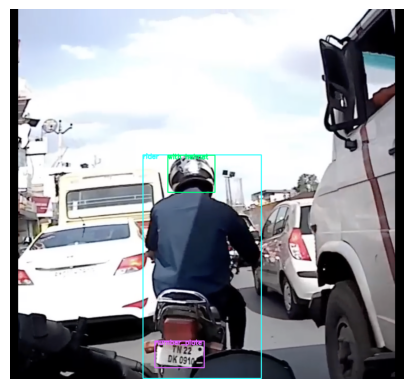

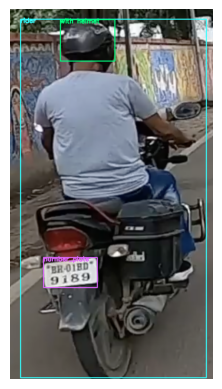

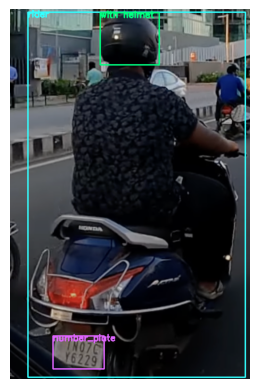

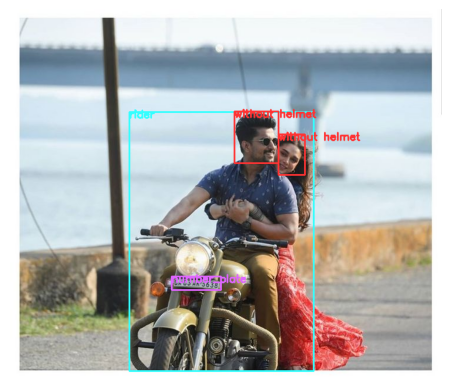

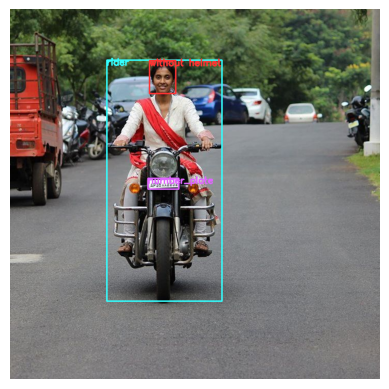

In [14]:
import os
import cv2
import random
from matplotlib import pyplot as plt

# Mapping class IDs to class labels
id2class_map = {
    '0': 'with helmet', 
    '1': 'without helmet', 
    '2': 'rider', 
    '3': 'number_plate'
}

# Define the main path to the dataset
main_path = "/kaggle/input/rider-with-helmet-without-helmet-number-plate"  

# Function to get bounding box and label information from label text files
def get_bbox_and_label(image_name, data_type='train', main_path=main_path):
    lbl_path = os.path.join(main_path, data_type, 'labels', f'{image_name}.txt')
    with open(lbl_path, 'r') as f:
        lines = f.readlines()
    
    bboxes = [
        [float(n) for n in line.split()[1:]]  # Extracting bbox as [x_center, y_center, width, height]
        for line in lines
    ]
    labels = [id2class_map[line.split()[0]] for line in lines]  # Mapping class IDs to class labels
    
    return bboxes, labels

# Function to load an image
def load_image(image_name, data_type='train', main_path=main_path):
    img_path = os.path.join(main_path, data_type, 'images', f'{image_name}.jpg')    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# Function to convert bounding box from normalized coordinates to pixel coordinates
def get_bbox_coordinates(img, bbox):
    img_height, img_width, _ = img.shape
    x_center, y_center, bbox_width, bbox_height = bbox
    
    # Calculate the coordinates of the bounding box
    x_center_pixel = x_center * img_width
    y_center_pixel = y_center * img_height
    half_width = bbox_width * img_width / 2
    half_height = bbox_height * img_height / 2
    
    x_min = int(x_center_pixel - half_width)
    y_min = int(y_center_pixel - half_height)
    x_max = int(x_center_pixel + half_width)
    y_max = int(y_center_pixel + half_height)
    
    return x_min, y_min, x_max, y_max

# Mapping class names to colors for bounding boxes
class2color_map = {
    'with helmet': (0, 255, 128),      # Green for 'with helmet'
    'without helmet': (255, 51, 51),   # Red for 'without helmet'
    'rider': (51, 255, 255),           # Yellow for 'rider'
    'number_plate': (224, 102, 255)    # Purple for 'number_plate'
}

# Function to plot image with bounding boxes and labels
def plot_image(image_name, data_type='train', class2color_map=class2color_map):
    img = load_image(image_name=image_name, data_type=data_type)
    bboxes, labels = get_bbox_and_label(image_name=image_name, data_type=data_type)
    
    for bbox, label in zip(bboxes, labels):
        color = class2color_map[label]  # Get color for the label
        x_min, y_min, x_max, y_max = get_bbox_coordinates(img, bbox)  # Get bbox coordinates
        
        # Draw bounding box with rectangle
        img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
        
        # Add label text on top of the bounding box
        img = cv2.putText(
            img,
            label,
            (x_min, y_min + 10),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.6,
            color=color,
            thickness=2
        )
    
    # Display the image using matplotlib
    plt.imshow(img)
    plt.axis('off')  # Hide axis for better visualization
    plt.show()

# Function to plot multiple random images from the training set
def plot_random_images(data_type='train', num_images=5):
    # Get all image filenames in the train folder
    image_files = [f.split('.')[0] for f in os.listdir(os.path.join(main_path, data_type, 'images')) if f.endswith('.jpg')]
    
    # Randomly select a few images
    selected_images = random.sample(image_files, num_images)
    
    # Plot each selected image with bounding boxes
    for image_name in selected_images:
        plot_image(image_name=image_name, data_type=data_type)

# Example: Plot 5 random training images with bounding boxes
plot_random_images(data_type='train', num_images=5)


In [15]:
import yaml

# read the content of coco128.yaml
with open(os.path.join(main_path, 'coco128.yaml'), 'r') as file:
    print(file.read())

train: /train/images
val: /val/images

nc: 4

names: ["with helmet", "without helmet", "rider", "number plate"]


In [16]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLOv8n model
model = YOLO('yolov8n.pt')

# Display model information (optional)
model.info()

100%|██████████| 6.25M/6.25M [00:00<00:00, 313MB/s]


YOLOv8n summary: 225 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

In [17]:
# creata the yaml based on coco128 for model training
data = {
    'train': '/kaggle/input/rider-with-helmet-without-helmet-number-plate/train',
    'val': '/kaggle/input/rider-with-helmet-without-helmet-number-plate/val',
    'nc': 4,
    'names': [
        'with helmet',
        'without helmet',
        'rider',
        'number plate'
    ]
}

with open('/kaggle/working/data.yaml', 'w') as file:
    yaml.dump(data, file)

# check the content of data.yaml
with open('/kaggle/working/data.yaml', 'r') as file:
    print(file.read())

names:
- with helmet
- without helmet
- rider
- number plate
nc: 4
train: /kaggle/input/rider-with-helmet-without-helmet-number-plate/train
val: /kaggle/input/rider-with-helmet-without-helmet-number-plate/val



In [18]:
# disable wandb
os.environ['WANDB_MODE'] = "disabled"


# command to train the YOLOv8 model
model.train(
    data='/kaggle/working/data.yaml',
    epochs=75,
    workers=1,
    batch=8,
)

Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=75, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=1, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

100%|██████████| 755k/755k [00:00<00:00, 83.9MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 253MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/rider-with-helmet-without-helmet-number-plate/train/labels... 102 images, 0 backgrounds, 2 corrupt: 100%|██████████| 104/104 [00:00<00:00, 158.40it/s]

train: WARNING ⚠️ /kaggle/input/rider-with-helmet-without-helmet-number-plate/train/images/new128.jpg: ignoring corrupt image/label: cannot identify image file '/kaggle/input/rider-with-helmet-without-helmet-number-plate/train/images/new128.jpg'
train: WARNING ⚠️ /kaggle/input/rider-with-helmet-without-helmet-number-plate/train/images/new3.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'mpo', 'tiff', 'heic', 'webp', 'jpg', 'png', 'bmp', 'dng', 'jpeg', 'pfm', 'tif'}
videos: {'gif', 'mp4', 'm4v', 'mov', 'avi', 'webm', 'asf', 'mpg', 'wmv', 'ts', 'mpeg', 'mkv'}
train: WARNING ⚠️ Cache directory /kaggle/input/rider-with-helmet-without-helmet-number-plate/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/rider-with-helmet-without-helmet-number-plate/val/labels... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 174.03it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/rider-with-helmet-without-helmet-number-plate/val is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 1 dataloader workers
Logging results to runs/detect/train
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/75      1.23G      1.084      3.494      1.295         27        640: 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         20         73     0.0193      0.435      0.228      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/75      1.21G     0.9467      2.454      1.152         48        640: 100%|██████████| 13/13 [00:02<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.73it/s]

                   all         20         73     0.0381      0.424      0.223       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/75      1.21G     0.9301      1.597      1.162         46        640: 100%|██████████| 13/13 [00:02<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]

                   all         20         73     0.0568      0.864      0.582      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/75      1.21G     0.9342      1.407      1.116         53        640: 100%|██████████| 13/13 [00:02<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]


                   all         20         73      0.864      0.259      0.647      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/75      1.21G     0.8867      1.264      1.086         53        640: 100%|██████████| 13/13 [00:02<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.43it/s]

                   all         20         73      0.723      0.286      0.632       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/75      1.21G      0.846      1.154      1.054         31        640: 100%|██████████| 13/13 [00:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.22it/s]


                   all         20         73      0.755      0.461       0.71      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/75      1.21G     0.8655      1.151      1.086         31        640: 100%|██████████| 13/13 [00:02<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.84it/s]


                   all         20         73      0.821       0.62      0.843      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/75      1.21G      0.888      1.129      1.092         52        640: 100%|██████████| 13/13 [00:02<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.50it/s]

                   all         20         73      0.763      0.655      0.862       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/75      1.21G     0.8662      1.046      1.075         46        640: 100%|██████████| 13/13 [00:02<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]

                   all         20         73      0.825      0.842      0.906      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/75      1.21G     0.8353     0.9971      1.043         43        640: 100%|██████████| 13/13 [00:02<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.56it/s]


                   all         20         73      0.838      0.819      0.919      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/75      1.21G     0.7895     0.9965      1.054         34        640: 100%|██████████| 13/13 [00:02<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.70it/s]

                   all         20         73       0.91      0.719       0.91      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/75      1.21G     0.7788     0.9362      1.013         40        640: 100%|██████████| 13/13 [00:02<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.31it/s]


                   all         20         73      0.864       0.82      0.896      0.699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/75      1.21G     0.7747     0.9343      1.026         54        640: 100%|██████████| 13/13 [00:02<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.48it/s]

                   all         20         73      0.886      0.818        0.9      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/75      1.21G     0.7948     0.9046      1.044         49        640: 100%|██████████| 13/13 [00:02<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.61it/s]


                   all         20         73      0.864      0.828      0.904      0.712

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/75      1.21G     0.7474     0.8623      1.008         34        640: 100%|██████████| 13/13 [00:02<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.65it/s]

                   all         20         73      0.884      0.866      0.911      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/75      1.21G     0.7651     0.8606      1.037         40        640: 100%|██████████| 13/13 [00:02<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.92it/s]


                   all         20         73      0.908      0.876      0.919      0.743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/75      1.21G     0.7677     0.8661      1.003         37        640: 100%|██████████| 13/13 [00:02<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


                   all         20         73      0.904      0.806      0.923      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/75      1.21G     0.7559     0.8315       1.01         37        640: 100%|██████████| 13/13 [00:02<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.61it/s]

                   all         20         73      0.887      0.831      0.921      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/75      1.21G      0.741     0.8317          1         53        640: 100%|██████████| 13/13 [00:02<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.48it/s]

                   all         20         73      0.896      0.812      0.906      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/75      1.21G     0.7171     0.7842       1.01         30        640: 100%|██████████| 13/13 [00:02<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.27it/s]


                   all         20         73      0.868      0.882      0.912      0.728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/75      1.21G     0.7124     0.7482      0.995         51        640: 100%|██████████| 13/13 [00:02<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.52it/s]

                   all         20         73      0.853      0.902      0.919      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/75      1.21G     0.7427     0.8129     0.9988         54        640: 100%|██████████| 13/13 [00:02<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.31it/s]


                   all         20         73      0.865      0.906      0.928       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/75      1.21G      0.715     0.7657      0.998         40        640: 100%|██████████| 13/13 [00:02<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]

                   all         20         73      0.861      0.879      0.912       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/75      1.21G     0.7032     0.7668      0.991         40        640: 100%|██████████| 13/13 [00:02<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.68it/s]

                   all         20         73      0.927      0.849      0.914      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/75      1.21G     0.7061     0.7662      1.003         43        640: 100%|██████████| 13/13 [00:02<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


                   all         20         73      0.895      0.876      0.926      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/75      1.21G     0.6941     0.7311      1.004         43        640: 100%|██████████| 13/13 [00:02<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.93it/s]

                   all         20         73      0.942      0.889      0.932      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/75      1.21G      0.678     0.7498      1.005         36        640: 100%|██████████| 13/13 [00:02<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.47it/s]

                   all         20         73      0.918       0.93      0.944      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/75      1.21G     0.6829     0.7109     0.9793         38        640: 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.31it/s]

                   all         20         73      0.939      0.906      0.946      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/75      1.21G     0.6929     0.7206     0.9814         54        640: 100%|██████████| 13/13 [00:02<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


                   all         20         73      0.894      0.942      0.946      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/75      1.21G     0.6528     0.6789     0.9782         65        640: 100%|██████████| 13/13 [00:02<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.58it/s]

                   all         20         73       0.91      0.953      0.951      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/75      1.21G     0.6574     0.6829     0.9915         33        640: 100%|██████████| 13/13 [00:02<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.86it/s]

                   all         20         73      0.932      0.934       0.95      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/75      1.21G     0.6418     0.6811     0.9608         47        640: 100%|██████████| 13/13 [00:02<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.32it/s]


                   all         20         73      0.914      0.906       0.95      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/75      1.21G     0.6754     0.6753     0.9985         41        640: 100%|██████████| 13/13 [00:02<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]


                   all         20         73      0.934      0.896      0.951      0.755

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/75      1.21G     0.6463     0.6719     0.9828         23        640: 100%|██████████| 13/13 [00:02<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.22it/s]


                   all         20         73      0.936      0.916      0.949      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/75      1.21G     0.6547     0.6588     0.9736         53        640: 100%|██████████| 13/13 [00:02<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]

                   all         20         73      0.916       0.92      0.953      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/75      1.21G      0.641     0.6514     0.9642         45        640: 100%|██████████| 13/13 [00:02<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


                   all         20         73       0.92      0.904      0.955      0.753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/75      1.21G     0.6301     0.6196     0.9557         51        640: 100%|██████████| 13/13 [00:02<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.53it/s]


                   all         20         73      0.916      0.895      0.955      0.758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/75      1.21G     0.6256     0.6329     0.9728         48        640: 100%|██████████| 13/13 [00:02<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]

                   all         20         73      0.894      0.895      0.941      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/75      1.21G     0.6634     0.6659          1         50        640: 100%|██████████| 13/13 [00:02<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.28it/s]


                   all         20         73      0.873      0.913      0.954      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/75      1.21G      0.596     0.6244      0.953         37        640: 100%|██████████| 13/13 [00:02<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.12it/s]

                   all         20         73      0.945        0.9      0.963      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/75      1.21G     0.6154     0.6123     0.9622         38        640: 100%|██████████| 13/13 [00:02<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.26it/s]

                   all         20         73      0.956      0.899      0.968       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/75      1.21G     0.6193      0.603     0.9417         38        640: 100%|██████████| 13/13 [00:02<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]

                   all         20         73      0.977      0.875      0.965       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/75      1.21G     0.5814     0.5868     0.9495         34        640: 100%|██████████| 13/13 [00:02<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.10it/s]

                   all         20         73      0.975      0.862       0.96      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/75      1.21G     0.5898      0.604     0.9465         46        640: 100%|██████████| 13/13 [00:02<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


                   all         20         73      0.959      0.889      0.951      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/75      1.21G     0.6134     0.6007     0.9467         59        640: 100%|██████████| 13/13 [00:02<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.83it/s]

                   all         20         73      0.955      0.884      0.948      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/75      1.21G     0.5574     0.5751     0.9336         48        640: 100%|██████████| 13/13 [00:02<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.03it/s]

                   all         20         73       0.97      0.872      0.944      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/75      1.21G      0.553     0.5459     0.9264         39        640: 100%|██████████| 13/13 [00:02<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]

                   all         20         73      0.971      0.871      0.941      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/75      1.21G     0.5764     0.5992     0.9608         36        640: 100%|██████████| 13/13 [00:02<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.43it/s]

                   all         20         73      0.942      0.896      0.944      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/75      1.21G     0.5477     0.5684      0.927         55        640: 100%|██████████| 13/13 [00:02<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


                   all         20         73      0.898      0.934      0.941      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/75      1.21G     0.5637     0.5592     0.9426         46        640: 100%|██████████| 13/13 [00:02<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.22it/s]

                   all         20         73      0.917      0.872      0.931      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/75      1.21G      0.574     0.5575      0.928         53        640: 100%|██████████| 13/13 [00:02<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.40it/s]

                   all         20         73      0.934      0.873      0.943      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/75      1.21G     0.5212     0.5363     0.9291         31        640: 100%|██████████| 13/13 [00:02<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.75it/s]

                   all         20         73      0.907      0.934      0.949      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/75      1.21G     0.5365     0.5477     0.9353         45        640: 100%|██████████| 13/13 [00:02<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


                   all         20         73      0.935      0.902      0.945      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/75      1.21G     0.5478     0.5358     0.9241         41        640: 100%|██████████| 13/13 [00:02<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.56it/s]

                   all         20         73      0.933      0.906      0.958      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/75      1.21G     0.5604     0.5427     0.9308         34        640: 100%|██████████| 13/13 [00:02<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.27it/s]

                   all         20         73      0.952      0.889      0.959       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/75      1.21G      0.524     0.5139     0.9316         26        640: 100%|██████████| 13/13 [00:02<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.74it/s]

                   all         20         73      0.959      0.889      0.956      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/75      1.21G     0.5149     0.5124      0.947         42        640: 100%|██████████| 13/13 [00:02<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.25it/s]

                   all         20         73      0.959      0.894      0.956      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/75      1.21G     0.5061     0.5193      0.919         42        640: 100%|██████████| 13/13 [00:02<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.68it/s]


                   all         20         73      0.958      0.895      0.958      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/75      1.21G     0.5182     0.5216     0.9285         47        640: 100%|██████████| 13/13 [00:02<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.92it/s]

                   all         20         73      0.957      0.889      0.962      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/75      1.21G     0.5107     0.5066     0.9265         49        640: 100%|██████████| 13/13 [00:02<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]

                   all         20         73      0.963      0.885      0.971      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/75      1.21G     0.5306     0.5207     0.9196         52        640: 100%|██████████| 13/13 [00:02<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]

                   all         20         73      0.954      0.888      0.971      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/75      1.21G     0.5322     0.5074     0.9229         43        640: 100%|██████████| 13/13 [00:02<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]

                   all         20         73      0.926      0.926      0.975      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/75      1.21G     0.4881     0.4765     0.9133         35        640: 100%|██████████| 13/13 [00:02<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]


                   all         20         73      0.947       0.93      0.977      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/75      1.21G     0.4973     0.4937     0.9237         51        640: 100%|██████████| 13/13 [00:02<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.82it/s]

                   all         20         73      0.947       0.93      0.979      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/75      1.22G     0.5035     0.5006     0.9221         47        640: 100%|██████████| 13/13 [00:02<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.80it/s]

                   all         20         73       0.98      0.876      0.979      0.828


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
      66/75      1.21G     0.4878     0.6378      0.889         24        640: 100%|██████████| 13/13 [00:03<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.56it/s]


                   all         20         73      0.981      0.878      0.979      0.827

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/75      1.21G     0.4609     0.5799     0.8832         19        640: 100%|██████████| 13/13 [00:02<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]

                   all         20         73      0.964      0.887      0.966      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/75      1.21G     0.4624     0.5441     0.8689         23        640: 100%|██████████| 13/13 [00:02<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.89it/s]

                   all         20         73      0.957      0.865      0.956      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/75      1.21G     0.4641     0.5648      0.869         23        640: 100%|██████████| 13/13 [00:01<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]

                   all         20         73      0.871      0.942      0.954      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/75      1.21G     0.4592     0.5514     0.8672         25        640: 100%|██████████| 13/13 [00:02<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.04it/s]

                   all         20         73      0.874      0.958      0.956      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/75      1.21G     0.4749     0.5526     0.8542         20        640: 100%|██████████| 13/13 [00:02<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.10it/s]

                   all         20         73       0.91      0.933      0.955      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/75      1.21G     0.4511     0.5219     0.8735         27        640: 100%|██████████| 13/13 [00:02<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.21it/s]

                   all         20         73       0.91      0.935      0.956      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/75      1.21G     0.4334     0.5143     0.8689         20        640: 100%|██████████| 13/13 [00:02<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.50it/s]

                   all         20         73      0.911      0.934      0.957      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/75      1.21G     0.4568     0.5263     0.8699         20        640: 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.48it/s]

                   all         20         73      0.913      0.934      0.957      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/75      1.21G     0.4413     0.5107     0.8583         21        640: 100%|██████████| 13/13 [00:02<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.92it/s]

                   all         20         73      0.912      0.935      0.957      0.783



75 epochs completed in 0.068 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


                   all         20         73       0.98      0.876      0.979      0.828
           with helmet         12         13          1      0.801      0.986      0.803
        without helmet         10         15      0.926      0.867      0.973      0.793
                 rider         20         23      0.995      0.913      0.967      0.874
          number plate         20         22          1      0.924      0.992       0.84
Speed: 0.2ms preprocess, 3.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a0a1baa81f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0


0: 544x640 1 with helmet, 1 rider, 1 number plate, 33.7ms
Speed: 2.1ms preprocess, 33.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


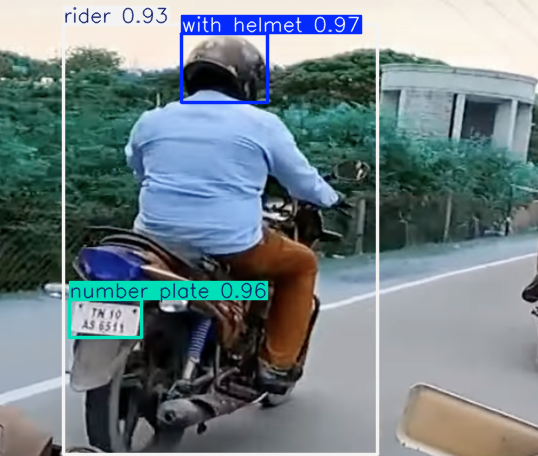

In [23]:
import torch
import cv2
from matplotlib import pyplot as plt
from ultralytics import YOLO

# Load the trained YOLOv8 model from the local path using the YOLO API
model_path = '/kaggle/working/runs/detect/train2/weights/best.pt'  # path to the saved weights
model = YOLO(model_path)  # Use YOLO class to load the model

# Function to perform object detection on an image
def detect_objects(image_path, model):
    # Load image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Perform inference
    results = model(img_rgb)  # Inference

    # Extract the first result (since we are working with one image here)
    result = results[0]

    # Show results on the image (draw boxes and labels)
    result.show()  # This will display the image with bounding boxes

# Example: Detect objects in a new image
image_path = '/kaggle/input/rider-with-helmet-without-helmet-number-plate/train/images/new11.jpg'  # Provide the path to the new image
detect_objects(image_path, model)



0: 544x640 1 with helmet, 1 rider, 1 number plate, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


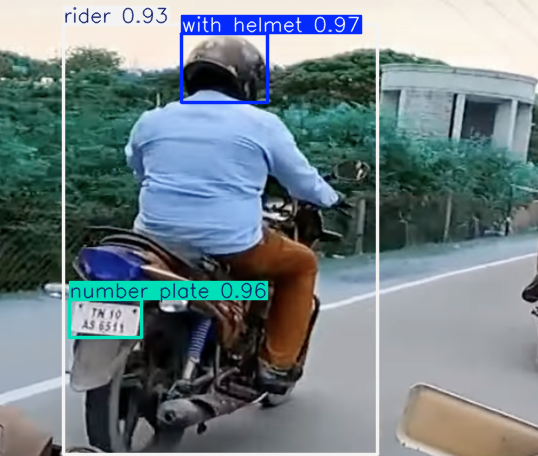

Detected Text: 
Detected Text: 
Detected Text: 


In [29]:
import torch
import cv2
from matplotlib import pyplot as plt
from ultralytics import YOLO
import easyocr
import numpy as np

# Load the trained YOLOv8 model from the local path using the YOLO API
model_path = '/kaggle/working/runs/detect/train2/weights/best.pt'  # path to the saved weights
model = YOLO(model_path)  # Use YOLO class to load the model

# Initialize EasyOCR reader for text recognition
reader = easyocr.Reader(['en'])  # Language: English

# Function to perform object detection and extract number plate details using EasyOCR
def detect_objects_and_extract_text(image_path, model, reader):
    # Load image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Perform inference
    results = model(img_rgb)  # Inference

    # Extract the first result (since we are working with one image here)
    result = results[0]

    # Show results on the image (draw boxes and labels)
    result.show()  # This will display the image with bounding boxes

    # Check if there are any detected boxes
    if len(result.boxes) == 0:
        print("No objects detected!")
        return

    # Iterate over detected boxes and apply OCR on the potential number plate regions
    for box in result.boxes:
        # Extract the coordinates of the bounding box (x1, y1, x2, y2)
        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())

        # Crop the region of interest (ROI) - number plate area
        cropped_img = img[y1:y2, x1:x2]

        # Convert the cropped image to grayscale for better OCR performance
        gray_cropped = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)

        # Apply thresholding to enhance contrast (helpful for text extraction)
        _, thresh_cropped = cv2.threshold(gray_cropped, 150, 255, cv2.THRESH_BINARY)

        # Visualize cropped image (for debugging)
        # plt.imshow(thresh_cropped, cmap='gray')
        # plt.show()

        # Use EasyOCR to extract text from the cropped region
        ocr_results = reader.readtext(thresh_cropped)

        # Filter and merge detected text fragments into a single string (if needed)
        detected_text = " ".join([result[1] for result in ocr_results]).strip()

        # Post-process the OCR result to clean it up
        detected_text = detected_text.replace(" ", "")  # Remove spaces between words

        # Optionally, filter out unwanted characters (e.g., non-alphanumeric)
        detected_text = ''.join(filter(str.isalnum, detected_text))

        # Print the combined OCR result (detected number plate)
        print("Detected Text:", detected_text)

# Example: Detect objects in a new image and extract number plate details
image_path = '/kaggle/input/rider-with-helmet-without-helmet-number-plate/train/images/new11.jpg'  # Provide the path to the new image
detect_objects_and_extract_text(image_path, model, reader)


In [1]:
!pip install pytesseract


In [2]:
!wget https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_russian_plate_number.xml?raw=true -O haarcascade_russian_plate_number.xml


--2024-12-16 06:19:28--  https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_russian_plate_number.xml?raw=true
Resolving github.com (github.com)... 4.237.22.38
Connecting to github.com (github.com)|4.237.22.38|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/opencv/opencv/raw/refs/heads/master/data/haarcascades/haarcascade_russian_plate_number.xml [following]
--2024-12-16 06:19:28--  https://github.com/opencv/opencv/raw/refs/heads/master/data/haarcascades/haarcascade_russian_plate_number.xml
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/opencv/opencv/refs/heads/master/data/haarcascades/haarcascade_russian_plate_number.xml [following]
--2024-12-16 06:19:28--  https://raw.githubusercontent.com/opencv/opencv/refs/heads/master/data/haarcascades/haarcascade_russian_plate_number.xml
Resolving raw.githubusercontent.com (raw.gith

In [3]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'



0: 640x640 1 with helmet, 1 without helmet, 2 riders, 2 number plates, 6.1ms
Speed: 2.2ms preprocess, 6.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Detected Text: 3


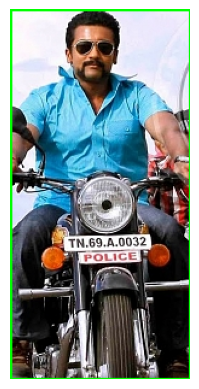

Detected Text: 3


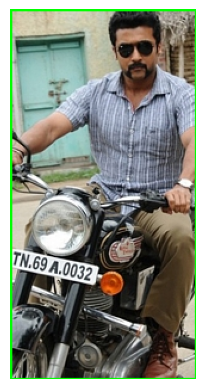

Detected Text: oe


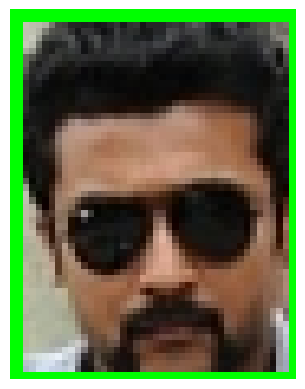

Detected Text: LE


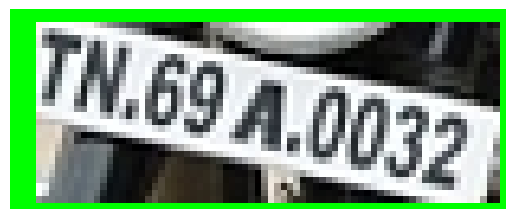

Detected Text: C2


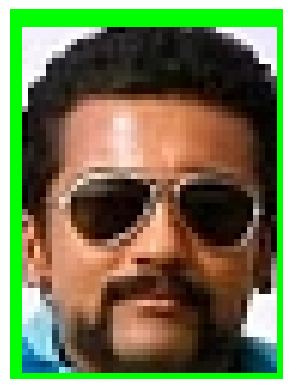

Detected Text: TN.69.A.0032 |


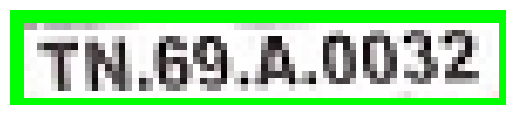

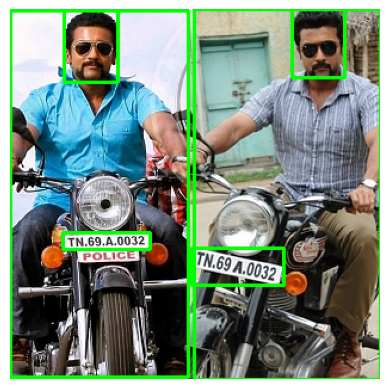

In [27]:
import torch
import cv2
import pytesseract
from matplotlib import pyplot as plt
from ultralytics import YOLO

# Load the pre-trained YOLOv8 model from the saved weights
model_path = '/kaggle/working/runs/detect/train/weights/best.pt'  # path to your YOLOv8 model weights
model = YOLO(model_path)  # Load YOLOv8 model

# Set the path for Tesseract executable
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

# Function to detect license plates using YOLO and extract text using Tesseract OCR
def detect_and_extract_plate(image_path, model):
    # Read image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Perform inference using YOLOv8
    results = model(img_rgb)  # Perform inference
    
    # Extract the first result (if we are working with one image)
    result = results[0]

    # Get bounding boxes and labels
    boxes = result.boxes
    if len(boxes) == 0:
        print("No license plate detected.")
        return None
    
    # Iterate through the detected boxes and extract license plate text
    for box in boxes:
        # Extract bounding box coordinates
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        
        # Draw a rectangle around the detected plate
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Crop the detected license plate region from the image
        plate_img = img[y1:y2, x1:x2]
        
        # Convert cropped image to grayscale for better OCR accuracy
        gray_plate = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
        
        # Apply OCR to the cropped license plate region
        text = pytesseract.image_to_string(gray_plate, config='--psm 8')
        
        # Print detected text
        print("Detected Text:", text.strip())
        
        # Display the cropped license plate image (optional)
        plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    # Display the full image with bounding boxes
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return img

# Example usage
image_path = '/kaggle/input/rider-with-helmet-without-helmet-number-plate/val/images/new127.jpg'  # Path to the image
img_with_plate = detect_and_extract_plate(image_path, model)



In [6]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 40.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



0: 640x384 2 with helmets, 3 without helmets, 1 rider, 2 number plates, 70.0ms
Speed: 2.0ms preprocess, 70.0ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 384)
Detected number plate with confidence: 0.97
Detected Text: 


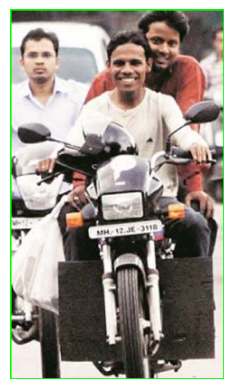

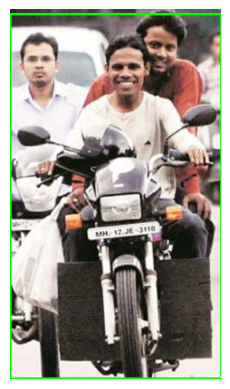

All Detected Texts: ['']


In [7]:
import cv2
import pytesseract
from matplotlib import pyplot as plt
from ultralytics import YOLO

# Load the pre-trained YOLOv8 model from the saved weights
model_path = r'runs\detect\train\weights\best.pt'  # Path to your YOLOv8 model weights
model = YOLO(model_path)  # Load YOLOv8 model

# Set the path for Tesseract executable (if running locally, update the path accordingly)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Function to detect license plates using YOLO and extract text using Tesseract OCR
def detect_and_extract_plate(image_path, model, number_plate_label=2):
    """
    Detect license plates using YOLO and extract their text using Tesseract OCR.
    
    Args:
    - image_path (str): Path to the image file.
    - model (YOLO): Loaded YOLO model.
    - number_plate_label (int): Class index for number plates in the YOLO model.
    
    Returns:
    - detected_texts (list): List of extracted texts from detected number plates.
    - img (ndarray): Image with bounding boxes drawn.
    """
    # Read the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Perform inference using YOLOv8
    results = model(img_rgb)
    result = results[0]  # Extract the first result
    
    # Get bounding boxes, labels, and confidence scores
    boxes = result.boxes
    if len(boxes) == 0:
        print("No objects detected.")
        return None, img

    detected_texts = []  # To store detected texts

    # Process each detected box
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
        label = int(box.cls)  # Class label index
        confidence = box.conf.item()  # Convert tensor to float
        
        # Check if the detected object is a number plate
        if label == number_plate_label and confidence > 0.5:  # Confidence threshold
            print(f"Detected number plate with confidence: {confidence:.2f}")
            
            # Draw a rectangle around the detected plate
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Crop the detected number plate region
            plate_img = img[y1:y2, x1:x2]
            
            # Convert cropped image to grayscale for better OCR accuracy
            gray_plate = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
            
            # Preprocess image: Resize and apply threshold (optional)
            gray_plate = cv2.resize(gray_plate, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
            _, thresh_plate = cv2.threshold(gray_plate, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Use Tesseract OCR to extract text
            text = pytesseract.image_to_string(thresh_plate, config='--psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
            detected_texts.append(text.strip())  # Add cleaned text to the list
            
            # Print detected text
            print("Detected Text:", text.strip())
            
            # Display the cropped license plate image (optional)
            plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

    # Display the full image with bounding boxes
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return detected_texts, img

# Example usage
image_path = r'train\images\new35.jpg'  # Path to the image
number_plate_class_label = 2  # Replace with the correct label index for number plates
detected_texts, img_with_plate = detect_and_extract_plate(image_path, model, number_plate_label=number_plate_class_label)

# Print all detected texts
if detected_texts:
    print("All Detected Texts:", detected_texts)
else:
    print("No license plates detected.")



0: 640x640 2 with helmets, 1 without helmet, 2 riders, 2 number plates, 68.0ms
Speed: 5.0ms preprocess, 68.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Detected Text: .
Detected Text: P
Detected Text: T1507 ee
Detected Text: e
Detected Text: TN, 69.4,0032.
Detected Text: —
Detected Text: —


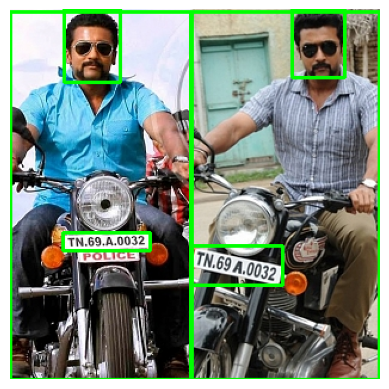

Detected plate: .
Detected plate: P
Detected plate: T1507 ee
Detected plate: e
Detected plate: TN, 69.4,0032.
Detected plate: —
Detected plate: —


In [11]:
import torch
import cv2
import pytesseract
from matplotlib import pyplot as plt
from ultralytics import YOLO

# Load the pre-trained YOLOv8 model from the saved weights
model_path = r'runs\detect\train\weights\best.pt'  # path to your YOLOv8 model weights
model = YOLO(model_path)  # Load YOLOv8 model

# Set the path for Tesseract executable
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Function to detect license plates using YOLO and extract text using Tesseract OCR
def detect_and_extract_plate(image_path, model):
    # Read image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Perform inference using YOLOv8
    results = model(img_rgb)  # Perform inference
    
    # Extract the first result (if we are working with one image)
    result = results[0]

    # Get bounding boxes and labels
    boxes = result.boxes
    if len(boxes) == 0:
        print("No license plate detected.")
        return img, None

    # Store detected text for output
    detected_texts = []

    # Iterate through the detected boxes and extract license plate text
    for box in boxes:
        # Extract bounding box coordinates
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # Draw a rectangle around the detected plate
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Crop the detected license plate region from the image
        plate_img = img[y1:y2, x1:x2]

        # Convert cropped image to grayscale for better OCR accuracy
        gray_plate = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
        
        # Apply denoising (optional but can help with noisy images)
        gray_plate = cv2.fastNlMeansDenoising(gray_plate, None, 30, 7, 21)
        
        # Apply thresholding for better OCR accuracy
        _, gray_plate = cv2.threshold(gray_plate, 127, 255, cv2.THRESH_BINARY)

        # Apply OCR to the cropped license plate region
        text = pytesseract.image_to_string(gray_plate, config='--psm 8')
        
        # Print detected text and store it for final output
        print(f"Detected Text: {text.strip()}")
        detected_texts.append(text.strip())

    # Return the image with bounding boxes and the detected text
    return img, detected_texts

# Example usage
image_path = r"val\images\new127.jpg"  # Path to the image
img_with_plate, detected_texts = detect_and_extract_plate(image_path, model)

# Display the full image with bounding boxes (only one image with all detections)
if img_with_plate is not None:
    plt.imshow(cv2.cvtColor(img_with_plate, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Display the extracted text for all detected plates
if detected_texts:
    for text in detected_texts:
        print(f"Detected plate: {text}")



0: 640x352 1 with helmet, 1 rider, 1 number plate, 128.0ms
Speed: 3.0ms preprocess, 128.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 352)
Detected Text: (eS)
Detected Text: Bea


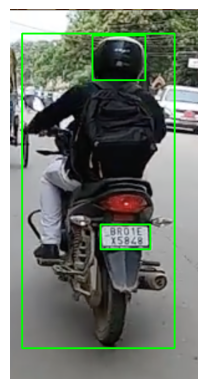

Detected plate: (eS)


In [28]:
import torch
import cv2
import pytesseract
from matplotlib import pyplot as plt
from ultralytics import YOLO

# Load the pre-trained YOLOv8 model from the saved weights
model_path = r'runs\detect\train\weights\best.pt'  # path to your YOLOv8 model weights
model = YOLO(model_path)  # Load YOLOv8 model

# Set the path for Tesseract executable
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Function to detect license plates using YOLO and extract text using Tesseract OCR
def detect_and_extract_plate(image_path, model):
    # Read image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Perform inference using YOLOv8
    results = model(img_rgb)  # Perform inference
    
    # Extract the first result (if we are working with one image)
    result = results[0]

    # Get bounding boxes and labels
    boxes = result.boxes
    if len(boxes) == 0:
        print("No license plate detected.")
        return img, None

    # Store detected text for output
    detected_texts = []

    # Iterate through the detected boxes and extract license plate text
    for box in boxes:
        # Extract bounding box coordinates
        x1, y1, x2, y2 = map(int, box.xyxy[0])

        # Draw a rectangle around the detected plate
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Crop the detected license plate region from the image
        plate_img = img[y1:y2, x1:x2]

        # Convert cropped image to grayscale for better OCR accuracy
        gray_plate = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
        
        # Apply denoising (optional but can help with noisy images)
        gray_plate = cv2.fastNlMeansDenoising(gray_plate, None, 30, 7, 21)
        
        # Apply adaptive thresholding (helps with varying light conditions)
        gray_plate = cv2.adaptiveThreshold(gray_plate, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                           cv2.THRESH_BINARY, 11, 2)

        # Optionally, apply Gaussian blur
        gray_plate = cv2.GaussianBlur(gray_plate, (5, 5), 0)

        # Apply OCR to the cropped license plate region
        text = pytesseract.image_to_string(gray_plate, config='--psm 8')
        
        # Filter out irrelevant results (e.g., empty strings or meaningless characters)
        if text.strip() and text.strip() != "." and len(text.strip()) > 2:  # Filter out small fragments
            print(f"Detected Text: {text.strip()}")
            detected_texts.append(text.strip())

    # If there are multiple results, merge them into one (if necessary)
    if detected_texts:
        # Choose the most relevant detected text (e.g., the longest valid text)
        final_text = max(detected_texts, key=len)
    else:
        final_text = None

    # Return the image with bounding boxes and the detected text
    return img, final_text

# Example usage
image_path = r"train\images\new2.jpg"  # Path to the image
img_with_plate, detected_plate = detect_and_extract_plate(image_path, model)

# Display the full image with bounding boxes (only one image with all detections)
if img_with_plate is not None:
    plt.imshow(cv2.cvtColor(img_with_plate, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Display the extracted text for all detected plates
if detected_plate:
    print(f"Detected plate: {detected_plate}")
else:
    print("No valid plate detected.")
